In [92]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np
from sklearn.metrics import pairwise_distances





In [93]:
# Load your dataset
df = pd.read_csv("us_popularity_index.csv") 

In [94]:
features = [
    'danceability', 'energy', 'speechiness', 'acousticness',
    'instrumentalness', 'liveness', 'valence', 'tempo', 'loudness', 
]

X = df[features].dropna()

print("Shape before dropping:", df.shape)
print("Shape after dropping:", X.shape)

Shape before dropping: (747, 27)
Shape after dropping: (747, 9)


In [95]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [96]:

# Run KMeans clustering. After trying multiple values we decided that 4 clusters is the best fit for our data.
k = 4 
kmeans = KMeans(n_clusters=k, random_state=42, n_init=100)
df['cluster'] = kmeans.fit_predict(X_scaled)

In [97]:
# Step 5: t-SNE for 2D projection
tsne = TSNE(n_components=2, perplexity=20, random_state=42)
tsne_result = tsne.fit_transform(X_scaled)
df['tsne1'] = tsne_result[:, 0]
df['tsne2'] = tsne_result[:, 1]

In [98]:
# Step 6: Outlier detection using t-SNE distance from cluster centroid
centroids = df.groupby('cluster')[['tsne1', 'tsne2']].mean().reset_index()

def compute_tsne_distance(row):
    center = centroids.loc[centroids['cluster'] == row['cluster'], ['tsne1', 'tsne2']].values[0]
    return np.linalg.norm([row['tsne1'] - center[0], row['tsne2'] - center[1]])

df['tsne_distance'] = df.apply(compute_tsne_distance, axis=1)
threshold = df['tsne_distance'].quantile(0.9)
df['is_outlier'] = df['tsne_distance'] > threshold

# Step 7: Save files
df.to_csv("dataset_clusters.csv", index=False)
df[df['is_outlier']].to_csv("outliers.csv", index=False)

print("Numers of outliers detected:", df['is_outlier'].sum())


Numers of outliers detected: 75


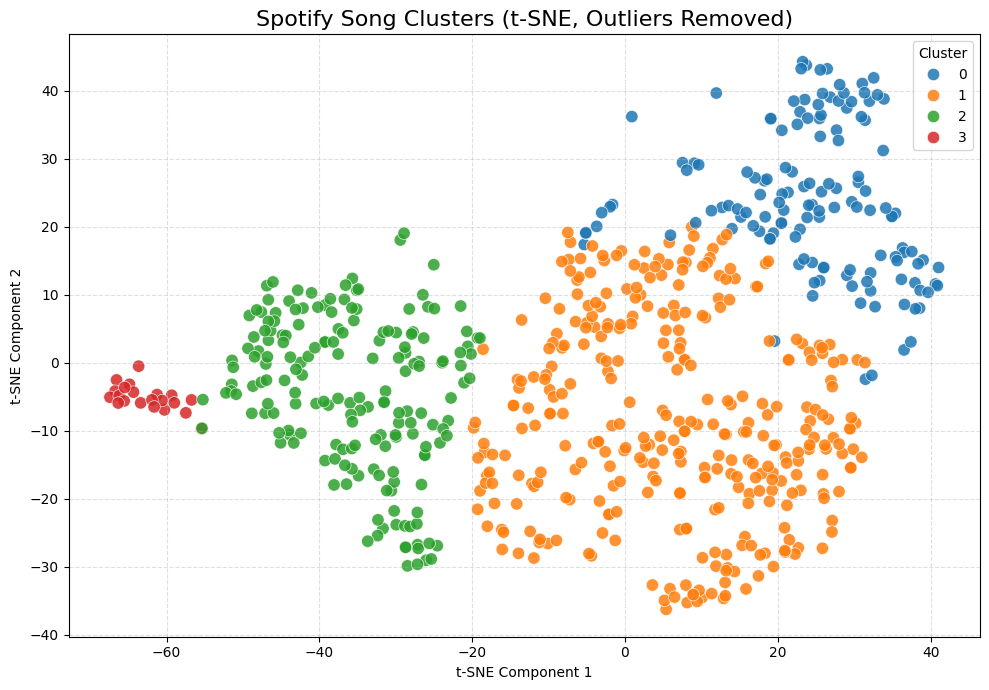

In [99]:
# Step 8: Fancy t-SNE plot (no outliers)
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df[~df['is_outlier']],
    x='tsne1', y='tsne2',
    hue='cluster',
    palette='tab10',
    s=80,
    alpha=0.85,
    edgecolor='white',
    linewidth=0.5
)
plt.title("Spotify Song Clusters (t-SNE, Outliers Removed)", fontsize=16)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Cluster", loc='best')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [100]:

# Print 10 far-apart songs per cluster
for cluster_id in sorted(df['cluster'].unique()):
    cluster_data = df[df['cluster'] == cluster_id].copy()
    tsne_coords = cluster_data[['tsne1', 'tsne2']].values

    # Compute pairwise distances
    distance_matrix = pairwise_distances(tsne_coords)

    # Greedy farthest-point sampling (maximize distance from selected points)
    selected_indices = [0]
    while len(selected_indices) < 10:
        remaining = list(set(range(len(cluster_data))) - set(selected_indices))
        farthest_idx = max(
            remaining,
            key=lambda i: min([distance_matrix[i, j] for j in selected_indices])
        )
        selected_indices.append(farthest_idx)

    # Retrieve the 10 songs
    diverse_songs = cluster_data.iloc[selected_indices]

    # Print results
    print(f"\n10 Diverse Songs from Cluster {cluster_id}:\n")
    for _, row in diverse_songs.iterrows():
        print(f"  - {row['name']} by {row['artists']} (Popularity Index: {row['popularity_index']:.2f})")



10 Diverse Songs from Cluster 0:

  - 4X4 by Travis Scott (Popularity Index: 0.71)
  - Take Your Mask Off (feat. Daniel Caesar & LaToiya Williams) by Tyler, The Creator, Daniel Caesar, LaToiya Williams (Popularity Index: 0.63)
  - This Sunday by Future, Metro Boomin (Popularity Index: 0.12)
  - Mmhmm by BigXthaPlug (Popularity Index: 0.58)
  - SMOKE HOUR ★ WILLIE NELSON by Beyoncé, Willie Nelson (Popularity Index: 0.35)
  - one of wun by Gunna (Popularity Index: 0.63)
  - Light Year (Practice) by Lil Uzi Vert (Popularity Index: 0.50)
  - letter to my brudda by 21 Savage (Popularity Index: 0.31)
  - man at the garden by Kendrick Lamar (Popularity Index: 0.70)
  - Empty Out Your Pockets by Juice WRLD (Popularity Index: 0.55)

10 Diverse Songs from Cluster 1:

  - Die With A Smile by Lady Gaga, Bruno Mars (Popularity Index: 0.95)
  - 7 Minute Drill by J. Cole (Popularity Index: 0.61)
  - THE DINER by Billie Eilish (Popularity Index: 0.58)
  - Home by Good Neighbours (Popularity Index: 0.

In [101]:
# Cluster size and average popularity
# We will use this to decide the best genre (cluster) for our concert. 
summary = df.groupby('cluster').agg(
    songs_in_cluster=('spotify_id', 'count'),
    avg_popularity_index=('popularity_index', 'mean')
).round(2)

print("\nCluster Summary:")
print(summary)



Cluster Summary:
         songs_in_cluster  avg_popularity_index
cluster                                        
0                     143                  0.49
1                     391                  0.53
2                     192                  0.49
3                      21                  0.60
